In [636]:
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

In [637]:
alpha = 1e-2
epsilon = 1e-8
max_iter = 5000
init_param = np.array([-1.5, 0.2])
sharp_a = 1
sharp_k = 0.3

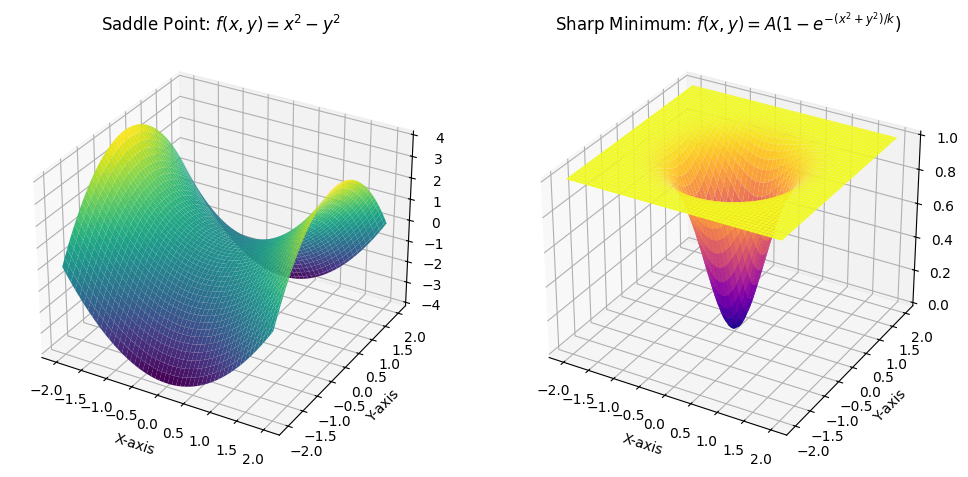

In [638]:
def saddle_point(x, y):
    return x**2 - y**2

def saddle_point_gradient(x, y):
    grad_x = 2 * x
    grad_y = -2 * y
    return np.array([grad_x, grad_y])

def sharp_minimum(x, y, A=1.0, k_factor=0.5):
    return A * (1 - np.exp(-(x**2 + y**2) / k_factor))

def sharp_minimum_gradient(x, y, A=1.0, k_factor=0.3):
    grad_x = (2 * A / k_factor) * x * np.exp(-(x**2 + y**2) / k_factor)
    grad_y = (2 * A / k_factor) * y * np.exp(-(x**2 + y**2) / k_factor)
    return np.array([grad_x, grad_y])

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, saddle_point(X, Y), cmap='viridis')
ax1.set_title("Saddle Point: $f(x,y)=x^2 - y^2$")
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, sharp_minimum(X, Y), cmap='plasma')
ax2.set_title("Sharp Minimum: $f(x,y)=A(1-e^{-(x^2+y^2)/k})$")
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
plt.show()

In [639]:
def plot_path(params_saddle, params_sharp, max_points_saddle=100, max_points_sharp=100):
    fig = plt.figure(figsize=(12, 6))
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, saddle_point(X, Y), cmap='cividis', alpha=0.6) 
    
    if params_saddle is not None and len(params_saddle) > 0:
        num_plot_saddle = min(max_points_saddle, len(params_saddle))
        
        plot_xs_saddle = params_saddle[:num_plot_saddle, 0]
        plot_ys_saddle = params_saddle[:num_plot_saddle, 1]
        plot_zs_saddle = saddle_point(plot_xs_saddle, plot_ys_saddle) 
        
        z_offset_saddle = (np.nanmax(saddle_point(X,Y)) - np.nanmin(saddle_point(X,Y))) * 0.02 if len(X)>0 else 0.05
        ax1.plot(plot_xs_saddle, plot_ys_saddle, plot_zs_saddle + z_offset_saddle, 
                 'ro-', linewidth=2, markersize=3, label='Optimization Path')
    
    ax1.set_title("Saddle Point: $f(x,y)=x^2 - y^2$")
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')
    ax1.set_zlabel('f(x,y)')
    ax1.legend(loc='upper left')
    ax1.view_init(elev=40, azim=30)


    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, sharp_minimum(X, Y, A=sharp_a, k_factor=sharp_k), cmap='cividis', alpha=0.6)
    
    if params_sharp is not None and len(params_sharp) > 0:
        num_plot_sharp = min(max_points_sharp, len(params_sharp))

        plot_xs_sharp = params_sharp[:num_plot_sharp, 0]
        plot_ys_sharp = params_sharp[:num_plot_sharp, 1]
        plot_zs_sharp = sharp_minimum(plot_xs_sharp, plot_ys_sharp, A=sharp_a, k_factor=sharp_k)

        z_offset_sharp = (np.nanmax(sharp_minimum(X,Y,A=sharp_a,k_factor=sharp_k)) - np.nanmin(sharp_minimum(X,Y,A=sharp_a,k_factor=sharp_k))) * 0.02 if len(X)>0 else 0.02
        ax2.plot(plot_xs_sharp, plot_ys_sharp, plot_zs_sharp + z_offset_sharp,
                 'ro-', linewidth=2, markersize=3, label='Optimization Path')
    
    ax2.set_title(f"Sharp Minimum: $f(x,y)={sharp_a}(1-e^{{-(x^2+y^2)/{sharp_k}}})$")
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    ax2.set_zlabel('f(x,y)')
    ax2.legend(loc='upper left')
    ax2.view_init(elev=30, azim=-75)
    
    plt.tight_layout(pad=1.5)
    plt.show()

In [640]:
# AdaGrad

def adagrad(params, mapping_func, alpha=1e-2, epsilon=1e-8, max_iter=1000):
    curr_params = params.copy()
    grad = mapping_func(curr_params[0], curr_params[1])
    accum_grads = np.zeros_like(curr_params)

    path = [curr_params.copy()]

    for i in range(max_iter):
        accum_grads += grad**2
        adjusted_grad = grad / (np.sqrt(accum_grads) + epsilon)
        curr_params -= alpha * adjusted_grad

        path.append(curr_params.copy())
        grad = mapping_func(curr_params[0], curr_params[1])

    return path

In [641]:
# RMSprop

def rmsprop(params, mapping_func, alpha=1e-2, beta=0.9, epsilon=1e-8, max_iter=1000):
    curr_params = params.copy()
    grads = mapping_func(curr_params[0], curr_params[1])
    accum_grads = np.zeros_like(params)

    path = [curr_params.copy()]
    
    for i in range(max_iter):
        accum_grads = beta * accum_grads + (1 - beta) * grads**2
        adjusted_grads = grads / (np.sqrt(accum_grads) + epsilon)
        curr_params -= alpha * adjusted_grads
        
        path.append(curr_params.copy())
        grads = mapping_func(curr_params[0], curr_params[1])

    return path

In [642]:
# AdaDelta

def adadelta(params, mapping_func, beta=0.9, epsilon=1e-8, max_iter=1000):
    curr_params = params.copy()
    grads = mapping_func(curr_params[0], curr_params[1])
    accum_grads = np.zeros_like(params)
    accum_updates = np.zeros_like(params)

    path = []
    
    for i in range(max_iter):
        accum_grads = beta * accum_grads + (1 - beta) * grads**2
        adjusted_grads = np.sqrt(accum_updates + epsilon) / (np.sqrt(accum_grads) + epsilon)
        curr_params -= adjusted_grads * grads
        
        accum_updates = beta * accum_updates + (1 - beta) * (adjusted_grads * grads)**2
        
        path.append(curr_params.copy())
        grads = mapping_func(curr_params[0], curr_params[1])

    return path

In [643]:
# Momentum

def momentum(params, mapping_func, alpha=1e-2, beta=0.9, epsilon=1e-8, max_iter=1000):
    curr_params = params.copy()
    grads = mapping_func(curr_params[0], curr_params[1])
    velocity = np.zeros_like(params)

    path = []
    
    for i in range(max_iter):
        velocity = beta * velocity - alpha * grads
        curr_params += velocity

        path.append(curr_params.copy())
        grads = mapping_func(curr_params[0], curr_params[1])

    return path

In [644]:
# NAG

def nag(params, mapping_func, alpha=1e-2, beta=0.9, epsilon=1e-8, max_iter=1000):
    curr_params = params.copy()
    velocity = np.zeros_like(params)

    path = []
    
    for i in range(max_iter):
        lookahead_params = curr_params + beta * velocity
        grads = mapping_func(lookahead_params[0], lookahead_params[1])
        velocity = beta * velocity - alpha * grads
        curr_params += velocity

        path.append(curr_params.copy())
        
    return path

In [645]:
# Adam

def adam(params, mapping_func, alpha=1e-2, beta1=0.9, beta2=0.99, epsilon=1e-8, max_iter=1000):
    curr_params = params.copy()
    grads = mapping_func(curr_params[0], curr_params[1])
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    path = []
    
    for i in range(max_iter):
        t += 1
        m = beta1 * m + (1 - beta1) * grads
        v = beta2 * v + (1 - beta2) * grads**2
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        curr_params -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)

        path.append(curr_params.copy())
        grads = mapping_func(curr_params[0], curr_params[1])

    return path

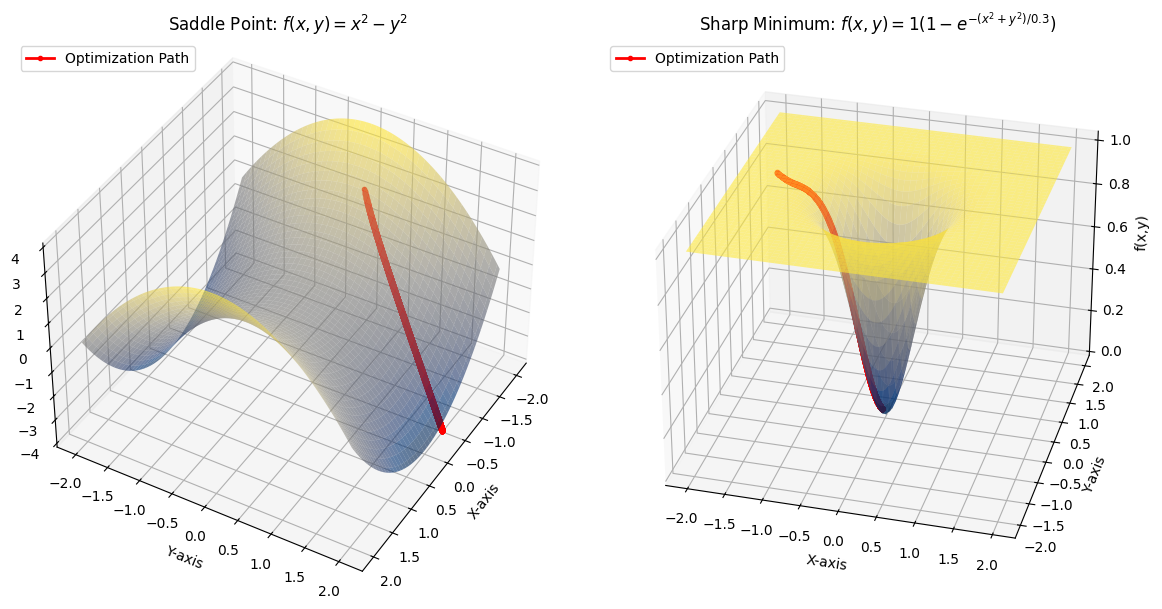

In [646]:
adagrad_path_saddle = adagrad(init_param, saddle_point_gradient, alpha=alpha, epsilon=epsilon, max_iter=max_iter)
adagrad_path_sharp = adagrad(init_param, sharp_minimum_gradient, alpha=alpha, epsilon=epsilon, max_iter=max_iter)

plot_path(np.array(adagrad_path_saddle), np.array(adagrad_path_sharp), max_points_saddle=5000, max_points_sharp=2700)

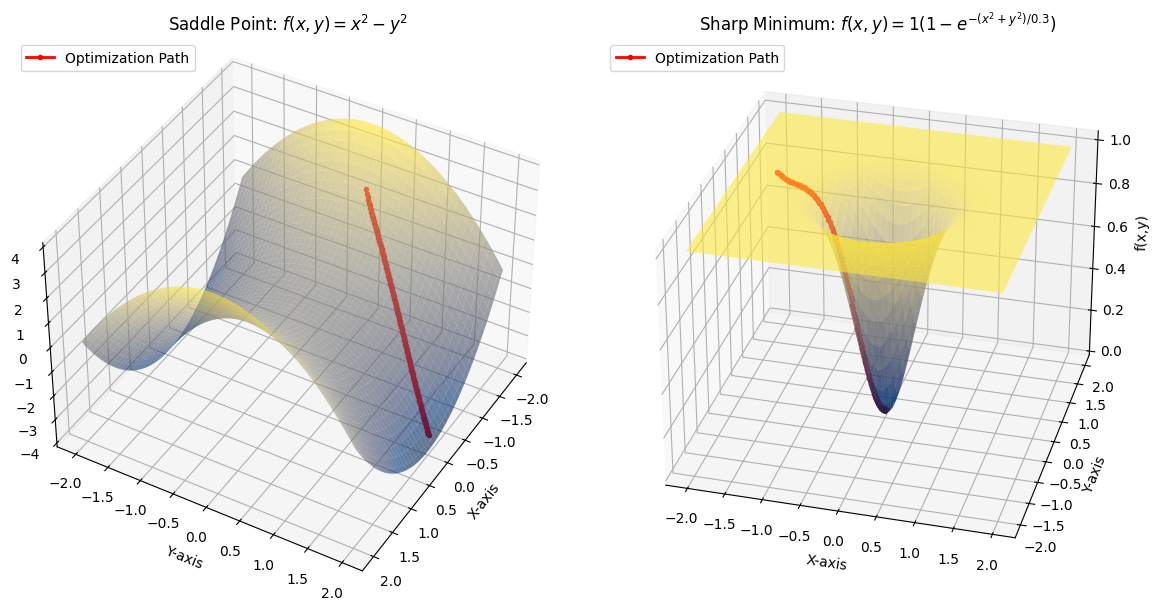

In [647]:
rmsprop_path_saddle = rmsprop(init_param, saddle_point_gradient, alpha=alpha, beta=0.9, epsilon=epsilon, max_iter=max_iter)
rmsprop_path_sharp = rmsprop(init_param, sharp_minimum_gradient, alpha=alpha, beta=0.9, epsilon=epsilon, max_iter=max_iter)

plot_path(np.array(rmsprop_path_saddle), np.array(rmsprop_path_sharp), max_points_saddle=150, max_points_sharp=150)

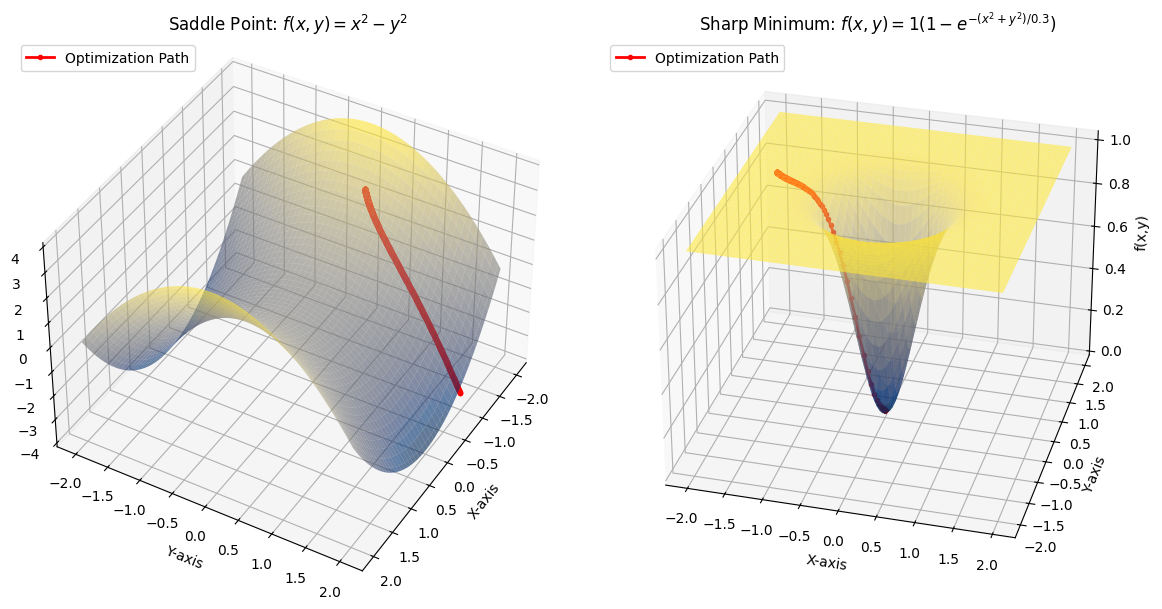

In [648]:
adadelta_path_saddle = adadelta(init_param, saddle_point_gradient, beta=0.9, epsilon=epsilon, max_iter=max_iter)
adadelta_path_sharp = adadelta(init_param, sharp_minimum_gradient, beta=0.9, epsilon=epsilon, max_iter=max_iter)

plot_path(np.array(adadelta_path_saddle), np.array(adadelta_path_sharp), max_points_saddle=950, max_points_sharp=350)

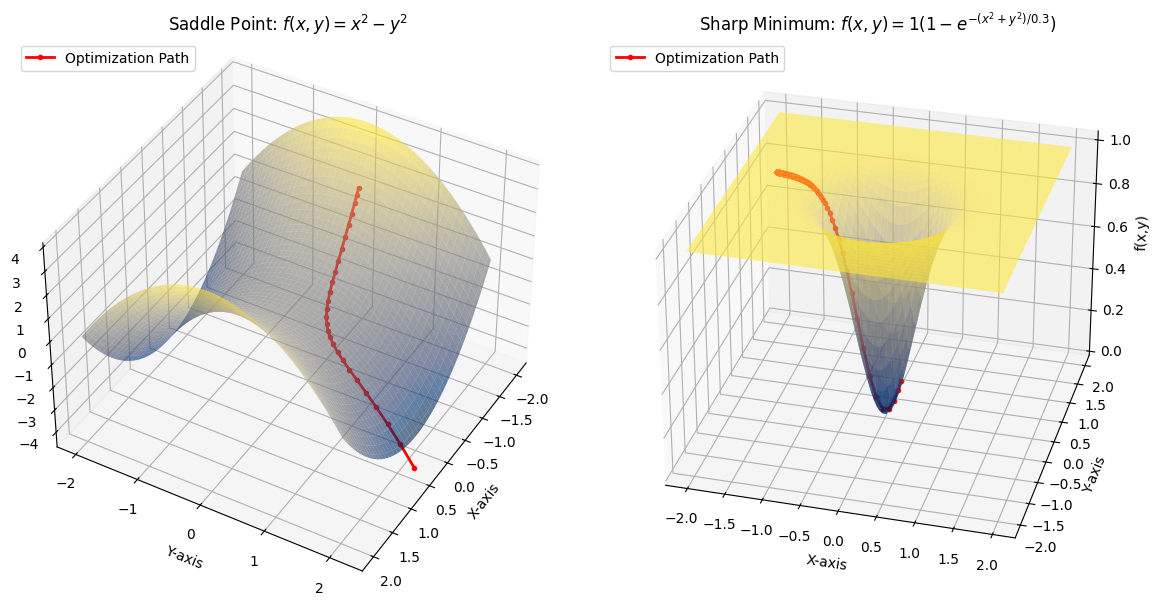

In [649]:
momentum_path_saddle = momentum(init_param, saddle_point_gradient, alpha=alpha, beta=0.9, epsilon=epsilon, max_iter=max_iter)
momentum_path_sharp = momentum(init_param, sharp_minimum_gradient, alpha=alpha, beta=0.9, epsilon=epsilon, max_iter=max_iter)

plot_path(np.array(momentum_path_saddle), np.array(momentum_path_sharp), max_points_saddle=27, max_points_sharp=294)

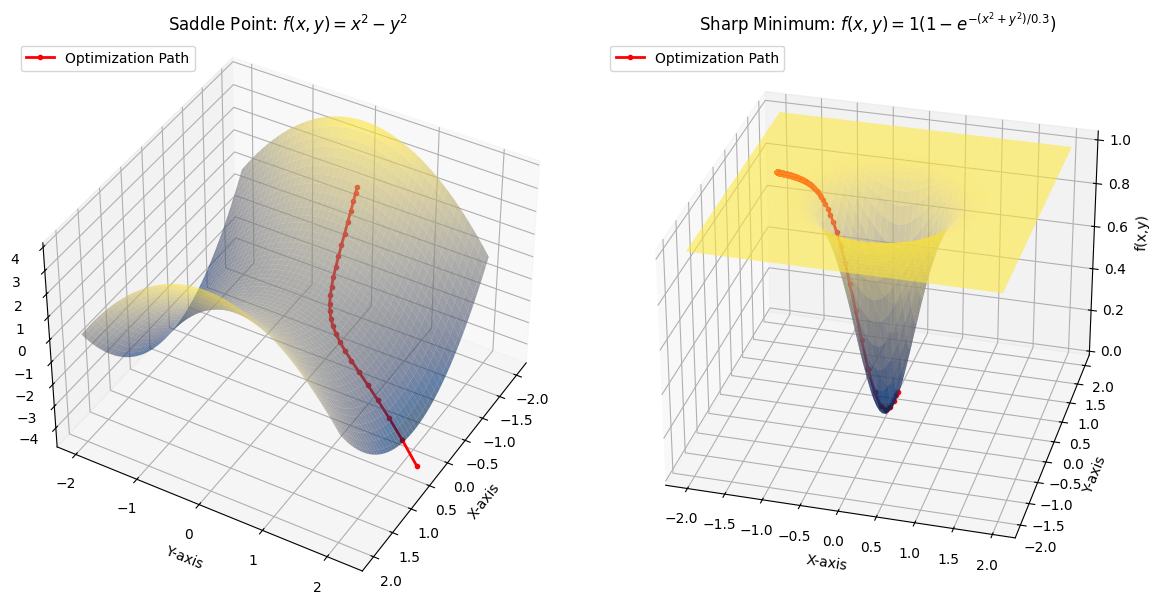

In [650]:
nag_path_saddle = nag(init_param, saddle_point_gradient, alpha=alpha, beta=0.9, epsilon=epsilon, max_iter=max_iter)
nag_path_sharp = nag(init_param, sharp_minimum_gradient, alpha=alpha, beta=0.9, epsilon=epsilon, max_iter=max_iter)

plot_path(np.array(nag_path_saddle), np.array(nag_path_sharp), max_points_saddle=26, max_points_sharp=291)

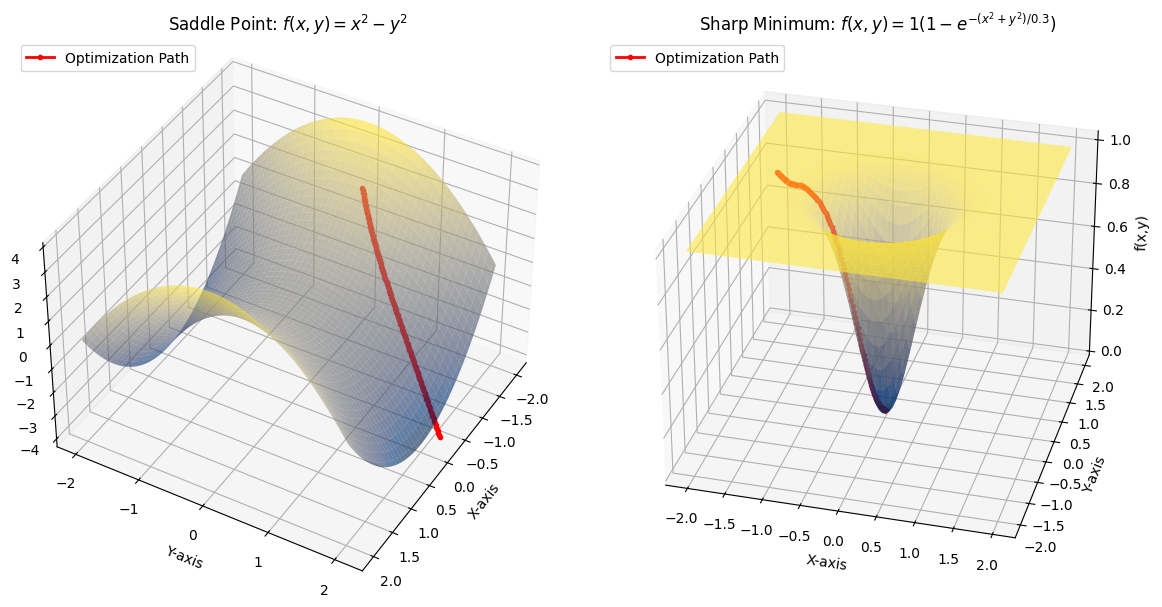

In [651]:
adam_path_saddle = adam(init_param, saddle_point_gradient, alpha=alpha, beta1=0.9, beta2=0.99, epsilon=epsilon, max_iter=max_iter)
adam_path_sharp = adam(init_param, sharp_minimum_gradient, alpha=alpha, beta1=0.9, beta2=0.99, epsilon=epsilon, max_iter=max_iter)

plot_path(np.array(adam_path_saddle), np.array(adam_path_sharp), max_points_saddle=150, max_points_sharp=115)